In [18]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [19]:
# from jax import config
# config.update("jax_enable_x64", True)

## Constants

In [20]:
X_START = 0
X_END = 1
T_START = 0
T_END = 0.2
NX = 8192
NT = int((T_END - T_START)/0.00005)
gamma = 1.4

## Space-Time Domain

In [21]:
x = jnp.linspace(X_START, X_END, NX)
dx = x[1] - x[0]

t = jnp.linspace(T_START, T_END, NT + 1)
dt = t[1] - t[0]

In [22]:
beta = dt/dx

## Initial Conditions

### primitive form of the flow variables in the form of ($\rho$, p, u)

In [23]:
rho = jnp.where(x <= 0.5, 1., 0.125)
p= jnp.where(x <= 0.5, 1., 0.1)
u = jnp.zeros(NX)

## Helper Functions

In [24]:
@jax.jit
def flux(con_variables, gamma):
    rho, rhou, rhoe = con_variables
    u = rhou/rho
    e = rhoe/rho
    p = rho*(gamma - 1.)*(e - 0.5*u**2)
    h = e + p/rho
    
    f1 = rhou
    f2 = rhou*u + p
    f3 = rhou*h
    
    return jnp.stack((f1, f2, f3))

@jax.jit
def con_2_prim(con_variables, gamma):
    rho, rhou, rhoe = con_variables
    u = rhou/rho
    e = rhoe/rho
    p = rho*(gamma - 1.)*(e - 0.5*u**2)
    return jnp.stack((rho, p, u))
    
@jax.jit
def prim_2_con(prim_variables, gamma):
    rho, p, u = prim_variables
    rhou = rho * u
    e = (p/(rho * (gamma - 1.))) + 0.5*u**2
    rhoe = rho*e
    return jnp.stack((rho, rhou, rhoe))

@jax.jit
def face_flux(qL, qR, fL, fR, gamma):
    gm = gamma - 1.

    rhoL, rhouL, rhoeL = qL
    uL = rhouL/rhoL
    eL = rhoeL/rhoL
    pL = rhoL*gm*(eL - 0.5*uL**2)
    aL = jnp.sqrt(gamma*pL/rhoL)
    
    rhoR, rhouR, rhoeR = qR
    uR = rhouR/rhoR
    eR = rhoeR/rhoR
    pR = rhoR*gm*(eR - 0.5*uR**2)
    aR = jnp.sqrt(gamma*pR/rhoR)
    
    SL = jax.lax.cond(uL > uR, lambda: uR, lambda: uL) - jax.lax.cond(aL > aR, lambda: aL, lambda: aR)
    SR = jax.lax.cond(uL > uR, lambda: uL, lambda: uR) + jax.lax.cond(aL > aR, lambda: aL, lambda: aR)
    
    SP = (pR - pL + rhoL*uL*(SL - uL) - rhoR*uR*(SR - uR))/(rhoL*(SL - uL) - rhoR*(SR - uR))

    DS = jnp.asarray((0., 1., SP))
        
    pLR = 0.5*(pL + pR + rhoL*(SL - uL)*(SP - uL) + rhoR*(SR - uR)*(SP - uR))
            
    f = jax.lax.cond(SL >= 0., lambda: fL, 
                     lambda: jax.lax.cond(SR <= 0., lambda: fR, 
                                      lambda: jax.lax.cond((SL <= 0.) & (SP >= 0.), lambda: ((SP * (SL*qL - fL) + SL*pLR*DS)/(SL - SP)), 
                                                    lambda: jax.lax.cond((SR >= 0.) & (SP < 0.), lambda: ((SP * (SR*qR - fR) + SR*pLR*DS)/(SR - SP)),
                                                                   lambda: jnp.zeros_like(fL)
                                                                  )
                                                    )
                                      )
                    )
    
    return f

In [25]:
# reconstructor for Left side
@jax.jit
def wcL(u_sliced):
    eps = 1e-6
    v1, v2, v3, v4, v5 = u_sliced
    
    s1 = (13. / 12.) * (v1 - 2. * v2 + v3)**2 + 0.25 * (v1 - 4. * v2 + 3. * v3)**2
    s2 = (13. / 12.) * (v2 - 2. * v3 + v4)**2 + 0.25 * (v2 - v4)**2
    s3 = (13. / 12.) * (v3 - 2. * v4 + v5)**2 + 0.25 * (3. * v3 - 4. * v4 + v5)**2
    
    c1 = 1e-1/(eps + s1)**2
    c2 = 6e-1/(eps + s2)**2
    c3 = 3e-1/(eps + s3)**2
    
    c_sum = c1 + c2 + c3
    
    w1 = c1/c_sum
    w2 = c2/c_sum
    w3 = c3/c_sum
    
    q1 = v1/3. - (7./6.) * v2 + (11./6.) * v3
    q2 = -v2/6. + (5./6.) * v3 + v4/3.
    q3 = v3/3. + (5./6.) * v4 - v5/6.
    
    return w1*q1 + w2*q2 + w3*q3


## reconstructor for the right side
@jax.jit
def wcR(u_sliced):
    eps = 1e-6
    v1, v2, v3, v4, v5 = u_sliced
    
    s1 = (13. / 12.) * (v1 - 2. * v2 + v3)**2 + 0.25 * (v1 - 4. * v2 + 3. * v3)**2
    s2 = (13. / 12.) * (v2 - 2. * v3 + v4)**2 + 0.25 * (v2 - v4)**2
    s3 = (13. / 12.) * (v3 - 2. * v4 + v5)**2 + 0.25 * (3. * v3 - 4. * v4 +  v5)**2
    
    c1 = 3e-1/(eps + s1)**2
    c2 = 6e-1/(eps + s2)**2
    c3 = 1e-1/(eps + s3)**2
    
    c_sum = c1 + c2 + c3
    
    w1 = c1/c_sum
    w2 = c2/c_sum
    w3 = c3/c_sum
    
    q1 = -v1/6. + (5./6.) * v2 +  v3/3.
    q2 = v2/3. + (5./6.) * v3 -  v4/6.
    q3 = (11./ 6.) * v3 - (7./6.) * v4 + v5/3.
    
    return w1*q1 + w2*q2 + w3*q3

In [26]:
@jax.jit
def wenoL(u, xs, index):
    
    def u_slices(index, x):
        def case_0_m_1(index, u):
            return wcL(jnp.asarray([u[2], u[1], u[0], u[0], u[1]]))
        def case_0(index, u): 
            return wcL(jnp.asarray([u[1], u[0], u[0], u[1], u[2]]))
        def case_1(index, u):
            return wcL(jnp.asarray([u[0], u[0], u[1], u[2], u[3]]))
        def case_N_m_2(index, u):
            return wcL(jnp.asarray([u[-4], u[-3], u[-2], u[-1], u[-1]]))
        def case_N_m_1(index, u):
            return wcL(jnp.asarray([u[-3], u[-2], u[-1], u[-1], u[-2]]))
        def normal(index, u):
            return wcL(jax.lax.dynamic_slice_in_dim(u, index - 2, 5))
        return jax.lax.switch(x, (normal, case_0_m_1, case_0, case_1, case_N_m_2, case_N_m_1), index, u)
    
    return u_slices(index, xs)

@jax.jit
def wenoR(u, xs, index):
    
    def u_slices(index, x):
        def case_0_m_1(index, u):
            return wcL(jnp.asarray([u[1], u[0], u[0], u[1], u[2]]))
        def case_0(index, u): 
            return wcL(jnp.asarray([u[0], u[0], u[1], u[2], u[3]]))
        def case_1(index, u):
            return wcL(jnp.asarray([u[-4], u[-3], u[-2], u[-1],  u[-1]]))
        def case_N_m_2(index, u):
            return wcL(jnp.asarray([u[-3], u[-2], u[-1], u[-1], u[-2]]))
        def case_N_m_1(index, u):
            return wcL(jnp.asarray([u[-2], u[-1], u[-1], u[-2], u[-3]]))
        def normal(index, u):
            return wcL(jax.lax.dynamic_slice_in_dim(u, index - 1, 5))
        return jax.lax.switch(x, (normal, case_0_m_1, case_0, case_1, case_N_m_2, case_N_m_1), index, u)
    
    return u_slices(index, xs)

In [27]:
mapped_wenoL = jax.vmap(jax.vmap(wenoL, in_axes=(0, None, None)), in_axes=(None, 0, 0), out_axes=1)
mapped_wenoR = jax.vmap(jax.vmap(wenoR, in_axes=(0, None, None)), in_axes=(None, 0, 0), out_axes=1)
mapped_flux = jax.vmap(flux, in_axes=(1, None), out_axes=1)
mapped_face_flux = jax.vmap(face_flux, in_axes=(1, 1, 1, 1, None), out_axes=1)

In [28]:
@jax.jit
def rhs(q, beta, xsL, xsR, gamma, index):
    
    qL = mapped_wenoL(q, xsL, index)
    qR = mapped_wenoR(q, xsR, index)
    
    flux_L, flux_R = mapped_flux(qL, gamma), mapped_flux(qR, gamma)
    
    flux_arr = mapped_face_flux(qL, qR, flux_L, flux_R, gamma)
        
    return -beta * (jax.lax.slice_in_dim(flux_arr, 1, None, axis=1) - jax.lax.slice_in_dim(flux_arr, 0, -1, axis=1))

In [29]:
@partial(jax.jit, static_argnames=('NX', 'NT'))
def hllc_num_loop(q, beta, NX, NT, gamma):
    
    xsL = jnp.zeros(NX + 1, dtype=jnp.int32)
    xsL = xsL.at[jnp.asarray((0, 1, 2, NX - 1, NX))].set(jnp.arange(1, 6))
    
    xsR = jnp.zeros(NX + 1, dtype=jnp.int32)
    xsR = xsR.at[jnp.asarray((0, 1, NX - 2, NX - 1, NX))].set(jnp.arange(1, 6))
    
    index = jnp.arange(-1, NX)
    
    def u_each_time_step(q_i, _):
        ## RK3 time integration
        q1, r= jnp.zeros((3, NX)), jnp.zeros((3, NX))
        
        r = r.at[:].set(rhs(q_i, beta, xsL, xsR, gamma, index))
        q1 = q1.at[:].set(q_i + r)

        r = r.at[:].set(rhs(q1, beta, xsL, xsR, gamma, index))
        q1 = q1.at[:].set(0.75*q_i + 0.25*(q1 + r))

        r = r.at[:].set(rhs(q1, beta, xsL, xsR, gamma, index))
        q_i = q_i.at[:].set((1./3.)*q_i + (2./3.)*(q1 + r))
        
        return q_i, q_i
    
    return jax.lax.scan(u_each_time_step, q, None, NT)

### conservative form of the flow variables in the form of ($\rho$, $\rho$*u, $\rho$*e)

In [30]:
q = prim_2_con(jnp.stack((rho, p, u)), gamma)

In [31]:
_, Q = hllc_num_loop(q, beta, NX, NT, gamma)

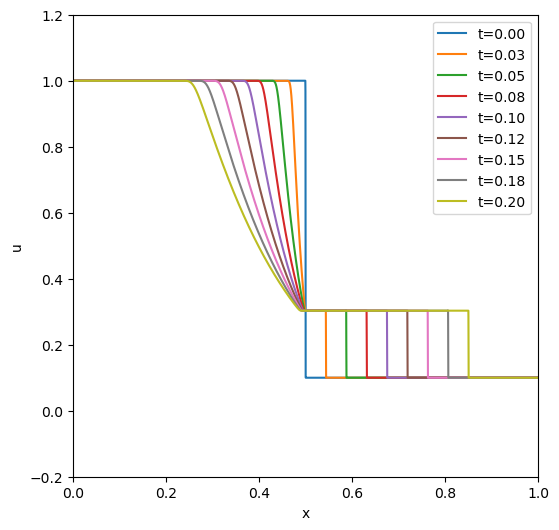

In [32]:
plt.figure(figsize=(6,6))
plt.xlabel("x")
plt.ylabel("u")
plt.xlim((0,1))
plt.ylim((-0.2,1.2))
#plt.title("Comparison of theoritical and numerical values @ t = 1")
for i in range(0, NT + 500, 500):    
    plt.plot(x, jax.vmap(con_2_prim,in_axes=(0,None))(Q[i].T, gamma)[:,1], label=f't={(i*dt):2.2f}')
plt.legend()
plt.show()